<a href="https://colab.research.google.com/github/icsd13152/X-RayImageClassification_DL/blob/main/X_RayImageClassification_With_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

Ποικίλες οι ιατρικές ανάγκες και παθοίσεις αλλά και οι εφαρμογές και εργαλεία για ανίχνευση αυτών. Είναι γεγονός ότι πολλές φορές το ανθρώπινο μάτι μπορεί να μην "πιάσει" κάποια πληρφορία που δεν είναι τόσο εφανή σε μια εικόνα. Ένας υπολογιστής όμως μπορεί. Στην παρούσα εργασία δημιουργώ ένα μοντέλο που βασίζεται στην Βαθιά μηχανική μάθηση αλλά και μοντέλα που προκύπτουν απο προ-εκπαιδευμένα Νευρωνικά Δίκτυα ή συνδιασμό μεθοδολογίας Deep Learning & Machine Learning. Τέλος για την κάθε πρόβλεψη και αποτέλεσμα εφαρμόζω τον αλγόριθμο GRADCam για το explainability αυτών. 

# Data

Τα δεδομένα συλλέχθηκαν απο το Kaggle στο παρακάτω link.
https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

In [1]:
# !pip install tensorflow==2.7.0
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow.keras.layers as layer
from tensorflow import keras
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A # for augmentation
!pip install -U tensorflow-addons
# !pip install kaggle
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
# sess = tf.session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.5 MB/s 
Num GPUs Available:  1


In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive')
# !unzip gdrive/My\ Drive/DeepLearning/archive.zip
# !tar -zcvf archive.tar.gz /content/drive/My\ Drive/DeepLearning/archive/COVID-19_Radiography_Dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/My Drive/DeepLearning/archive/COVID-19_Radiography_Dataset'


# Read Data From Drive

In [ ]:
Dirs = ['Normal', 'COVID', 'Viral Pneumonia','Lung_Opacity']
path = 'COVID-19_Radiography_Dataset'
data_dir = os.path.join(base_path)
#read images and get them to DataFrame
data = []
for id, level in enumerate(Dirs):
    lvl = level+'/images'
    for file in os.listdir(os.path.join(data_dir, lvl)):
        data.append(['{}/{}'.format(lvl, file), level])
data = pd.DataFrame(data, columns = ['image', 'lung_state'])
data['path'] = path + '/' + data['image']
data['lung_state'] = data['lung_state'].map({'Normal': 'Normal', 'COVID': 'Covid', 'Viral Pneumonia':'Pneumonia','Lung_Opacity':'Lung Opacity'})

print(data.head(5))


                           image lung_state  \
0  Normal/images/Normal-9451.png     Normal   
1  Normal/images/Normal-8972.png     Normal   
2  Normal/images/Normal-8984.png     Normal   
3  Normal/images/Normal-9063.png     Normal   
4  Normal/images/Normal-9401.png     Normal   

                                                path  
0  COVID-19_Radiography_Dataset/Normal/images/Nor...  
1  COVID-19_Radiography_Dataset/Normal/images/Nor...  
2  COVID-19_Radiography_Dataset/Normal/images/Nor...  
3  COVID-19_Radiography_Dataset/Normal/images/Nor...  
4  COVID-19_Radiography_Dataset/Normal/images/Nor...  


In [ ]:
# drive.mount('/content/drive')
# base_path = '/content/drive/My Drive/DeepLearning/archive/
# dir = ['newImages']
# data_dir2 = os.path.join('My Drive/DeepLearning/archive/')
# data2 = []
# for id, level in enumerate(dir):
#     lvl = level+'/images'
#     for file in os.listdir(os.path.join(data_dir2, lvl)):
#         data2.append(['{}/{}'.format(lvl, file), level])
# data2 = pd.DataFrame(data2, columns = ['image', 'lung_state'])
# data2['path'] = path + '/' + data2['image']
# data2['lung_state'] = data2['lung_state'].map({'Viral Pneumonia':'Pneumonia'})

# print(data.head(5))

# Get and plot the frequency of each Class

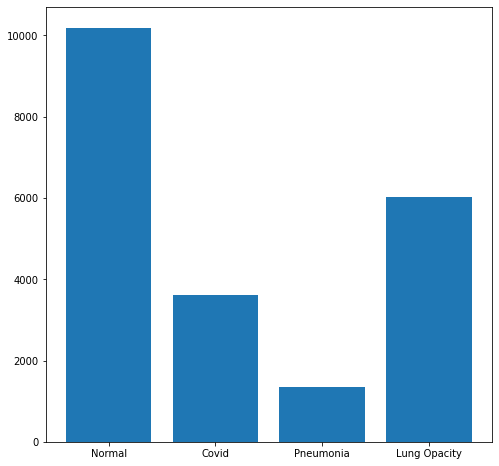

In [ ]:
frequency=[len(data[data['lung_state'] == 'Normal']), len(data[data['lung_state'] == 'Covid']), len(data[data['lung_state'] == 'Pneumonia']),len(data[data['lung_state'] == 'Lung Opacity'])]
plt.figure(figsize=(8,8))
plt.bar(["Normal","Covid","Pneumonia","Lung Opacity"], frequency)
plt.show()

Υπάρχει αρκετά σημαντικό imbalance πρόβλημα και θα προσπαθήσω να κάνω augmentation για την "μικρή" κλάση.

# Show some Images for each Class

Ας δούμε πως μοιάζουν οι εικόνες για κάθε κλάση. Για παράδειγμα ας πάρουμε 3 απο την κάθε κλάση.

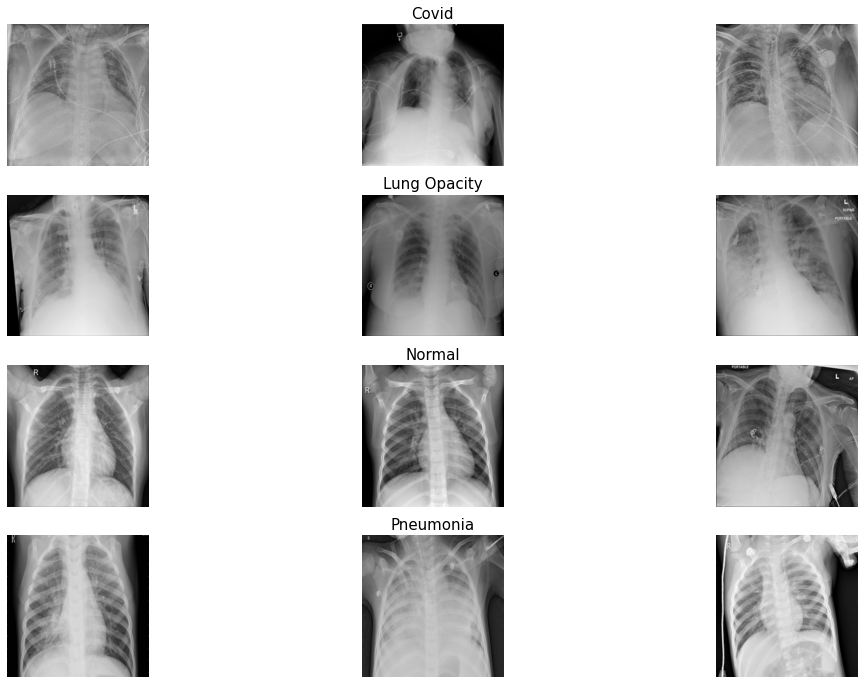

In [ ]:
n_images = 3

fig, m_axs = plt.subplots(4, n_images, figsize = (6*n_images, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['lung_state']).groupby('lung_state')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_images, random_state = 1234).iterrows()):       
        picture = '/content/drive/My Drive/DeepLearning/archive/'+c_row['path']
   
        image = cv2.imread(picture)

        c_ax.imshow(image)
        c_ax.axis('off')



Ας δούμε το resolution κάποιων εικόνων ώστε να δούμε τι διαστάσεις έχουμε για να κάνουμε το απαραίτητο resize. Σύμφωνα με τα specifications του Dataset θα πρέπει όλες οι εικόνες να είναι 299*299.

Text(0, 0.5, 'height')

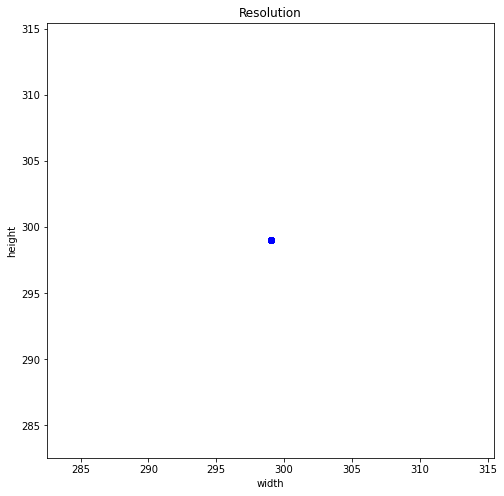

In [ ]:
n_images = 10
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
width = list()
height = list()
for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['lung_state']).groupby('lung_state')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_images, random_state = 1234).iterrows()):
         pic = '/content/drive/My Drive/DeepLearning/archive/'+c_row['path']
         image = cv2.imread(pic)
        #  print(image.shape)
         width.append(image.shape[0])
         height.append(image.shape[1])
points = ax.scatter(width,height,color = 'blue')
ax.set_title("Resolution")
ax.set_xlabel("width")
ax.set_ylabel("height")




Με βάση το παραπάνω plot των Frequencies per class παρατηρούμε οτι η Κλάση Pneumonia έχει αρκετά λιγότερα δείγματα και γενικότερα υπάρχει μια ανομοιογένεια. Για αυτό τον λόγο θα εφαρμόσουμε Data Augmentation ώστε να παραχθούν οι ίδιες εικόνες απλά με άλλη αεπικόνιση, όπως για παράδειγμα κάποιυ είδους Rotation. Διότι σε ένα πραγματικό σενάριο θα πρέπει η εφαρμογή να είναι σε θέση να διαβάζει και εικόνες που δίνουμε input ανάποδα. 
Θα επιλέξουμε προσεκτικά το τι Data Augmentation Θα κάνουμε καθώς δεν θέλουμε να επιρεάσουμε το train. Δηλαδή δεν θα μπορούσε μια εικόνα ακτινογραφίας να είναι πολύχρωμη. Θα πρέπει επομένως να σκεφτούμε και το τι ανταποκρίνεται στην πραγματικότητα.  
Τέλος βλέπουμε οτι οι εικόνες είναι του ίδιου μεγέθους.

# Data Augmentation

Έχει πραγματοποιήθει η παρακάτω διαδικασία αλλά δεν άλλαξε τα αποτελέσματα. Επίσης λόγω Limitation της vRam του Colab δεν μπορούμε να κάνουμε enchanced το augmentation process. Ωστόσο ο κώδικας είναι σχολιασμένος με σκοπό να μην το ξανα τρέξω, διότι εκτλέστηκε μια φορά και έχουν αποθηκευτεί npy αρχεία για τις εικόνες στο drive. Οπότε γλυτώνω με αυτό το processing και τo overload της vRam.

In [ ]:
# def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
#     fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
#     fig.suptitle(main_title, fontsize = 18)
#     fig.subplots_adjust(wspace = 0.3)
#     fig.subplots_adjust(hspace = 0.3)
    
#     for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
#         myaxes[i // ncols][i % ncols].imshow(img)
#         myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
#     plt.show()

COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-31.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-329.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1179.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1206.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-14.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-336.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-308.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1161.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-372.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-565.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-532.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-371.png
COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1166.png
COVID-19_R

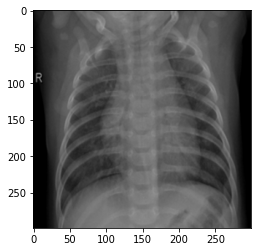

In [ ]:
# picture = data.path[0]

# def augmentationImage(image_path):
#     picture = base_path+"/Viral Pneumonia/images/Viral Pneumonia-10.png"
#     chosen_image = cv2.imread('/content/drive/My Drive/DeepLearning/archive/'+image_path)


#     albumentation_list = [A.RandomBrightness(p = 1),
#                           A.RandomContrast(limit = 0.5, p = 1)]
#                           # A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
#                           # A.RGBShift(p = 1), A.VerticalFlip(p = 1), , A.RandomGamma(p=1)]

#     img_matrix_list = []
#     bboxes_list = []
#     for aug_type in albumentation_list:
#         img = aug_type(image = chosen_image)['image']
#         img_matrix_list.append(img)

#     return img_matrix_list


# # img_matrix_list.insert(0,chosen_image)    
# ##
# # titles_list = ["Original", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast","RandomGamma"]

# # plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")
# listOfNewImages = list()
# for i in range(len(data)):
  
#     if data['lung_state'][i] == "Pneumonia":
#        image_path = data.path[i]
#        print(image_path)
#        newImages = augmentationImage(image_path)
#        for im in newImages:
#            listOfNewImages.append(im)

# plt.imshow(listOfNewImages[3])
# image_gen = ImageDataGenerator(
#                     # rescale=1./255,
#                     rotation_range=45,
#                     width_shift_range=.15,
#                     height_shift_range=.15,
#                     horizontal_flip=True,
#                     zoom_range=0.2 # 0.5
#                     )
# train_data_gen = image_gen.flow_from_directory(
#                                                directory=train_dir,
#                                                shuffle=True,
#                                                target_size=(IMG_HEIGHT, IMG_WIDTH))


In [ ]:
# from PIL import Image 
# import PIL 
# import shutil  
# path = '/content/drive/My Drive/DeepLearning/archive/newImages'
# i = 0  
# for image in listOfNewImages:
#     i += 1
#     im1 = Image.fromarray(image)
#     name = "Viral Pneumonia-aug"+str(i)+".png"
#     im1 = im1.save(name)
#     shutil.copy(name,path)

Ας δούμε τα στοιχεία μιας τυχαίας εικόνας με Covid.

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


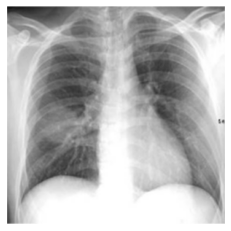

In [ ]:
image = cv2.imread(path+"/COVID/images/COVID-1002.png")
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))
plt.figure()

plt.imshow(image)
plt.axis('off')
plt.show() 



# Train/Validation/Test Split

Αφού έχουμε τα δεδομένα μας, ας κάνουμε την γνωστή διαδικασία του spliting για το cross validation.

In [ ]:
import shutil
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
   
    image = cv2.resize(image, (70, 70)) / 255.0
    if data['lung_state'][i] == "Normal":
      label = 0
    elif data['lung_state'][i] == "Covid":
      label = 1
    elif data['lung_state'][i] == "Pneumonia":
      label = 2
    else:
      label = 3
    
    all_data.append([image, label])


x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)
# Some classification problems do not have a balanced number of examples for each class label. As such, 
# it is desirable to split the dataset into train 
# and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42,stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42,stratify=y_train)
drive.mount('/content/drive')
np.save('trainsetX_as_nparray.npy',x_train)
np.save('trainsetY_as_nparray.npy',y_train)
np.save('valsetX_as_nparray.npy',x_val)
np.save('valsetY_as_nparray.npy',y_val)
np.save('testsetX_as_nparray.npy',x_test)
np.save('testsetY_as_nparray.npy',y_test)
# shutil.copy("testsetX_as_nparray.npy",base_path)
# shutil.copy("testsetY_as_nparray.npy",base_path)
print("X_train shape = ",x_train.shape)
print("Y_train shape = ",y_train.shape)
print("=================================")
print("X_val shape = ",x_val.shape)
print("Y_val shape = ",y_val.shape)
print("=================================")
print("X_test shape = ",x_test.shape)
print("Y_test shape = ",y_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train shape =  (10909, 70, 70, 3)
Y_train shape =  (10909,)
X_val shape =  (1213, 70, 70, 3)
Y_val shape =  (1213,)
X_test shape =  (3031, 70, 70, 3)
Y_test shape =  (3031,)


In [ ]:
# all_data2 = []
# drive.mount('/content/drive')
# base_path = '/content/drive/My Drive/DeepLearning/archive'
# dir = ['newImages']
# data_dir2 = os.path.join(base_path)
# data2 = []
# for id, level in enumerate(dir):
#     lvl = level
#     for file in os.listdir(os.path.join(data_dir2, lvl)):
#         data2.append(['{}/{}'.format(lvl, file), level])
# data2 = pd.DataFrame(data2, columns = ['image', 'lung_state'])
# data2['path'] = base_path + '/' + data2['image']
# data2['lung_state'] = data2['lung_state'].map({'Viral Pneumonia':'Pneumonia'})

# print(data2.path[0])

# for i in range(len(data2)):
#     image = cv2.imread(data2['path'][i])
   
#     image = cv2.resize(image, (70, 70)) / 255.0
#     label = 2
#     all_data2.append([image, label])
# x = []
# y = []

# for image, label in all_data2:
#     x.append(image)
#     y.append(label)

# # Converting to Numpy Array    
# x_train2 = np.array(x)
# y_train2 = np.array(y)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DeepLearning/archive/newImages/Viral Pneumonia-aug1691.png


In [ ]:
# p = '/content/drive/My Drive/DeepLearning/archive/DataAsnpArray/WithoutLungOpacity/'
# shutil.copy("testsetX_as_nparray.npy",p)
# shutil.copy("testsetY_as_nparray.npy",p)
# shutil.copy("trainsetX_as_nparray.npy",p)
# shutil.copy("trainsetY_as_nparray.npy",p)
# shutil.copy("valsetX_as_nparray.npy",p)
# shutil.copy("valsetY_as_nparray.npy",p)

'/content/drive/My Drive/DeepLearning/archive/DataAsnpArray/WithoutLungOpacity/valsetY_as_nparray.npy'

Για να γλυτώσω χρόνο σε κάθε πείραμά μου έχω αποθηκεύσει τα numpy arrays των εικόνων (δηλαδή τις τιμές των pixels) σε npy αρχεία με σκοπό να κάνω απλά ένα load. 

In [3]:
drive.mount('/content/drive/')
path = '/content/drive/My Drive/DeepLearning/archive/DataAsnpArray/'
x_train = np.load(path+'trainsetX_as_nparray.npy')
y_train = np.load(path+'trainsetY_as_nparray.npy')
x_val = np.load(path+'valsetX_as_nparray.npy')
y_val = np.load(path+'valsetY_as_nparray.npy')
x_test = np.load(path+'testsetX_as_nparray.npy')
y_test = np.load(path+'testsetY_as_nparray.npy')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# print(x_train.shape)
# print(x_train2.shape)
# x_train = np.concatenate((x_train,x_train2))
# print(x_train.shape)
# y_train = np.concatenate((y_train,y_train2))

(15238, 70, 70, 3)
(2690, 70, 70, 3)
(17928, 70, 70, 3)


In [ ]:
from keras import backend as K
from sklearn.metrics import precision_recall_fscore_support,precision_score,recall_score,f1_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

weights = compute_class_weight(class_weight = 'balanced', classes=np.unique(y_train), y=y_train)
cw = dict(zip( np.unique(y_train), weights))
def avg_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def avg_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def avg_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = avg_precision(y_true, y_pred)
    recall = avg_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# My Models

Δημιουργήθηκαν 4 διαφορετικά μοντέλα με σκοπό να πάρουμε το καλύτερο τόσο σε Performance αλλά και σε συνδιασμό με το πλήθος παραμέτρων.

In [ ]:
import keras
# !pip install keras_metrics
import keras_metrics
def createNeuralNet():
  model = Sequential()    #128

  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
  # model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
                            #64
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
                            #64
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(Dropout(0.3)) #0.5 without cw
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(4,activation = 'softmax')) #for Covid/Normal/Pneumonia/Lung_opacity maybe we need activation softmax

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#learning_rate=0.001
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                # run_eagerly=True,

                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),keras_metrics.sparse_categorical_recall(label=0,name='recall_Normal'),
                         keras_metrics.sparse_categorical_recall(label=1,name='recall_Covid'),
                         keras_metrics.sparse_categorical_recall(label=2,name='recall_Pneumonia'),
                         keras_metrics.sparse_categorical_recall(label=3,name='recall_LungOP')]#tf.keras.metrics.SparseCategoricalAccuracy()
                ) #tfa.metrics.F1Score(num_classes=4, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) tfa.metrics.f_scores.F1Score(num_classes=104,average="macro")
  model.summary()
  return model

In [ ]:
def createNeuralNet2():
  model = Sequential()    #128

  model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
  # model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
                            #64
  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
                            #64
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(Dropout(0.3)) #0.5 without cw
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(4,activation = 'softmax')) #for Covid/Normal/Pneumonia/Lung_opacity maybe we need activation softmax

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#learning_rate=0.001
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                # run_eagerly=True,
                # update_weights=True,
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),keras_metrics.sparse_categorical_recall(label=0,name='recall_Normal'),
                         keras_metrics.sparse_categorical_recall(label=1,name='recall_Covid'),
                         keras_metrics.sparse_categorical_recall(label=2,name='recall_Pneumonia'),
                         keras_metrics.sparse_categorical_recall(label=3,name='recall_LungOP')]#tf.keras.metrics.SparseCategoricalAccuracy()
                ) #tfa.metrics.F1Score(num_classes=4, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) tfa.metrics.f_scores.F1Score(num_classes=104,average="macro")
  model.summary()
  return model

In [ ]:
def createNeuralNet3():
  model = Sequential()    

  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
  # model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
                           
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
                            
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3)) #0.5 without cw
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(4,activation = 'softmax')) #for Covid/Normal/Pneumonia/Lung_opacity maybe we need activation softmax

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#learning_rate=0.001
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                # run_eagerly=True,
                # update_weights=True,
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),keras_metrics.sparse_categorical_recall(label=0,name='recall_Normal'),
                         keras_metrics.sparse_categorical_recall(label=1,name='recall_Covid'),
                         keras_metrics.sparse_categorical_recall(label=2,name='recall_Pneumonia'),
                         keras_metrics.sparse_categorical_recall(label=3,name='recall_LungOP')]#tf.keras.metrics.SparseCategoricalAccuracy()
                ) #tfa.metrics.F1Score(num_classes=4, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) tfa.metrics.f_scores.F1Score(num_classes=104,average="macro")
  model.summary()
  return model

In [ ]:
def createNeuralNet4():
  model = Sequential()    #128

  model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
                            #64
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
                            #64
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  
  model.add(Dropout(0.3)) #0.5 without cw
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(4,activation = 'softmax')) #for Covid/Normal/Pneumonia/Lung_opacity maybe we need activation softmax

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#learning_rate=0.001
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                # run_eagerly=True,
                # update_weights=True,
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),keras_metrics.sparse_categorical_recall(label=0,name='recall_Normal'),
                         keras_metrics.sparse_categorical_recall(label=1,name='recall_Covid'),
                         keras_metrics.sparse_categorical_recall(label=2,name='recall_Pneumonia'),
                         keras_metrics.sparse_categorical_recall(label=3,name='recall_LungOP')]#tf.keras.metrics.SparseCategoricalAccuracy()
                ) #tfa.metrics.F1Score(num_classes=4, threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) tfa.metrics.f_scores.F1Score(num_classes=104,average="macro")
  model.summary()
  return model

Ας δούμε τον γράφο του μοντέλου μας.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

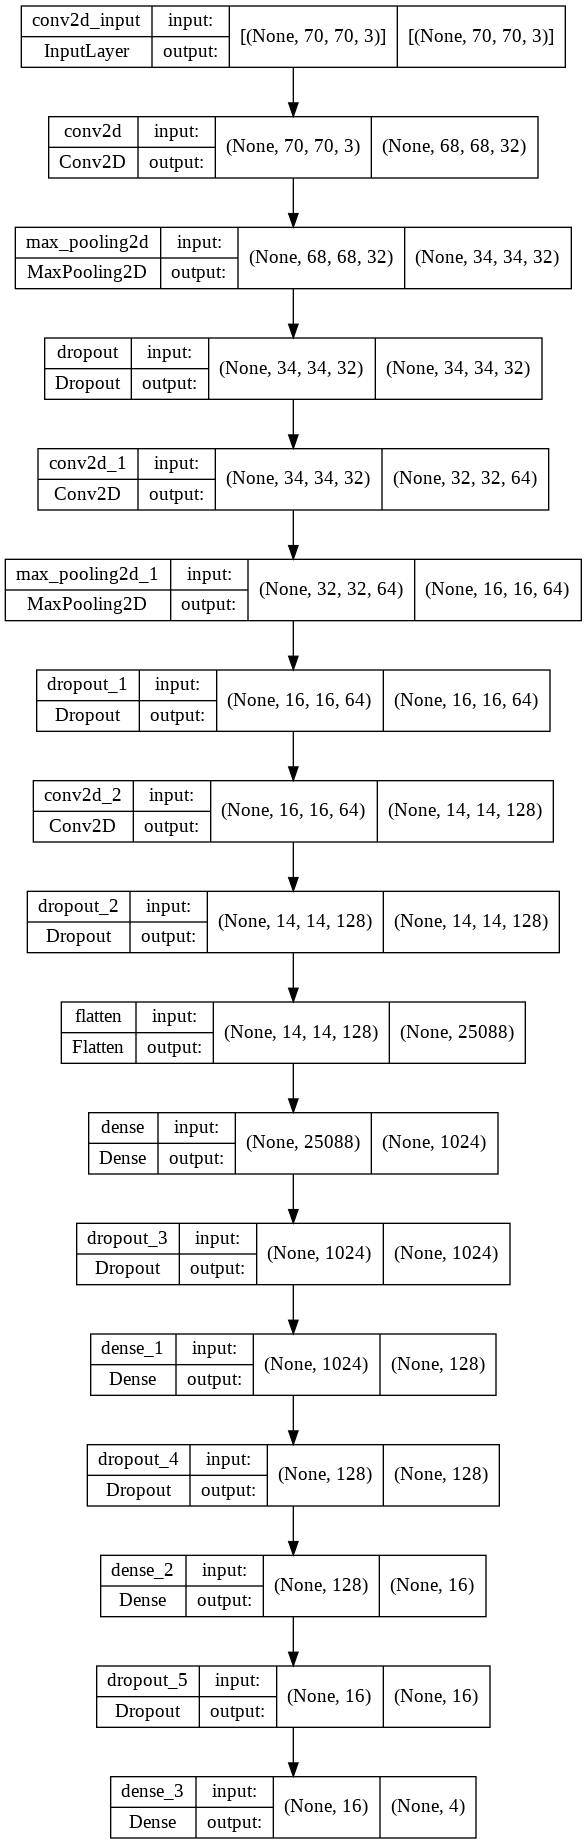

In [ ]:
model1 = createNeuralNet()
plot_model(model1,show_shapes=True, to_file="model1.png",show_layer_names=True, rankdir='TB', expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 68, 68, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 34, 34, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)       

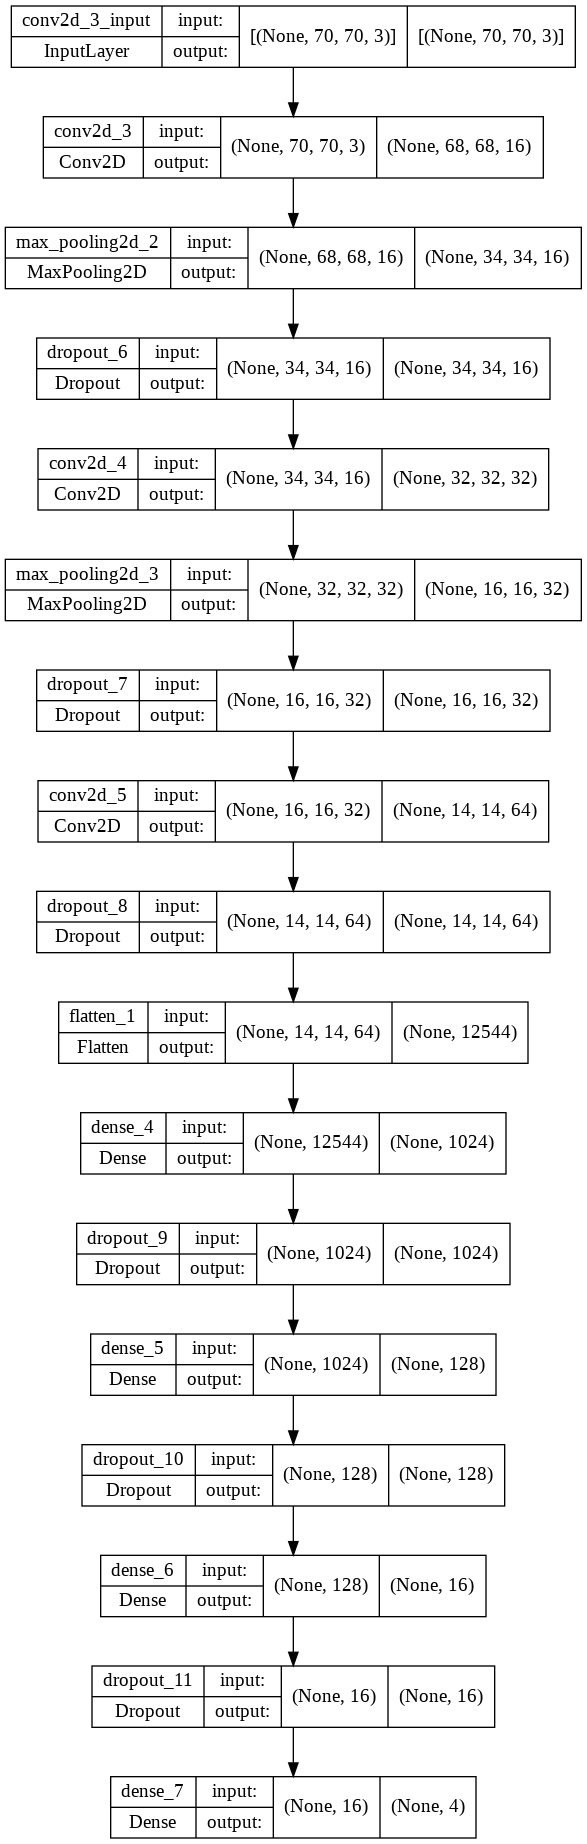

In [ ]:
model2 = createNeuralNet2()
plot_model(model2,show_shapes=True, to_file="model2.png",show_layer_names=True, rankdir='TB', expand_nested=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 68, 68, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 68, 68, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 34, 34, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)      

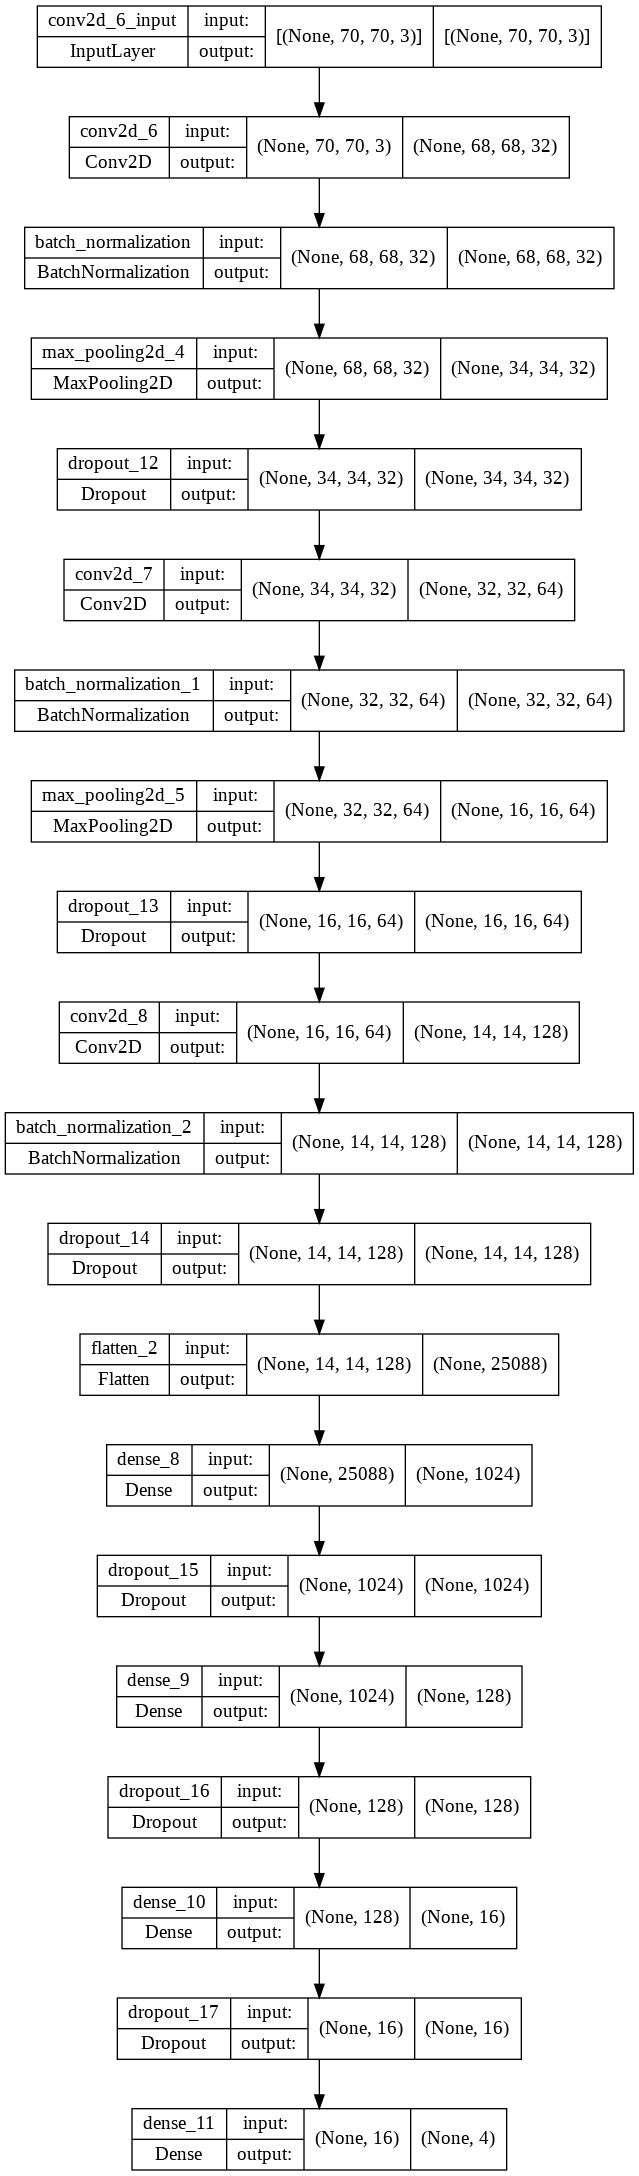

In [ ]:
model3 = createNeuralNet3()
plot_model(model3,show_shapes=True, to_file="model3.png",show_layer_names=True, rankdir='TB', expand_nested=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 68, 68, 16)        448       
                                                                 
 conv2d_10 (Conv2D)          (None, 66, 66, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 33, 33, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                  

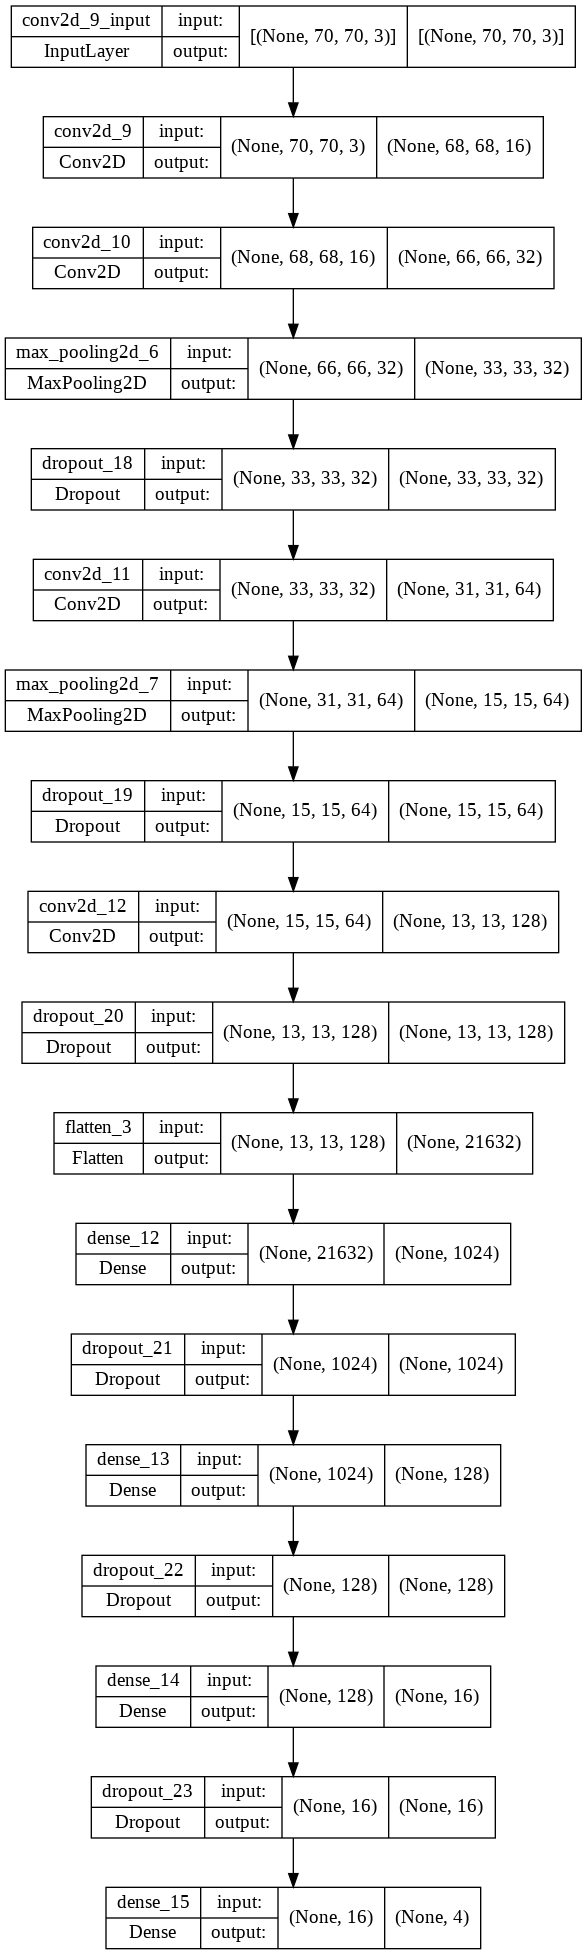

In [ ]:
model4 = createNeuralNet4()
plot_model(model4,show_shapes=True, to_file="model4.png",show_layer_names=True, rankdir='TB', expand_nested=True)

# Training

Θα εφαρμόσω τεχνική Early Stopping όταν βρεθεί η μιρκότερη loss τιμή του validation set. (Για 3 συνεχόμενες εποχές)

In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
# checkpoint = 'myCNNmodelv2.pt'
model = model1
checkpoint = 'myCNNmodel1_finalv2.h5'
checkpointW = 'myCNNmodel1_W_finalv2.h5'
checkpoint_dir = os.path.dirname(checkpoint)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpointW,
                                                save_weights_only=True,
                                                save_freq ='epoch',
                                                 monitor='val_loss', mode='min',
                                                patience = 3,
                                                save_best_only=True,
                                                verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

tf.random.set_seed(42)
history = model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 128,  
                        validation_data = (x_val, y_val),
                        # class_weight=cw, 
                        callbacks = [early_stopping,cp_callback])
# model.save(checkpoint)
model.save_weights('total'+checkpointW)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


120/120 [==============================] - ETA: 0s - loss: 1.1415 - sparse_categorical_accuracy: 0.4766 - recall_Normal: 0.1999 - recall_Covid: 0.0000e+00 - recall_Pneumonia: 0.0000e+00 - recall_LungOP: 0.0220WARNING:tensorflow:`add_update` `inputs` kwarg has been deprecated. You no longer need to pass a value to `inputs` as it is being automatically inferred.

Epoch 1: val_loss improved from inf to 0.86661, saving model to myCNNmodel1_W_finalv2.h5
120/120 [==============================] - 20s 53ms/step - loss: 1.1415 - sparse_categorical_accuracy: 0.4766 - recall_Normal: 0.1999 - recall_Covid: 0.0000e+00 - recall_Pneumonia: 0.0000e+00 - recall_LungOP: 0.0220 - val_loss: 0.8666 - val_sparse_categorical_accuracy: 0.6547 - val_recall_Normal: 0.4152 - val_recall_Covid: 0.0000e+00 - val_recall_Pneumonia: 0.0000e+00 - val_recall_LungOP: 0.1200
Epoch 2/50
119/120 [============================>.] - ETA: 0s - loss: 0.8055 - sparse_categorical_accuracy: 0.6748 - recall_Normal: 0.5090 - recall_

In [ ]:

checkpoint2 = 'myCNNmodel2_finalv2.h5'
checkpointW2 = 'myCNNmodel2_W_finalv2.h5'
checkpoint_dir = os.path.dirname(checkpoint)

cp_callback2 = tf.keras.callbacks.ModelCheckpoint(checkpointW2,
                                                save_weights_only=True,
                                                save_freq ='epoch',
                                                monitor='val_loss', mode='min',
                                                patience = 3,
                                                save_best_only=True,
                                                verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

tf.random.set_seed(42)
history2 = model2.fit(x_train, y_train, 
                        epochs = 50, batch_size = 128,  
                        validation_data = (x_val, y_val),
                        # class_weight=cw, 
                        callbacks = [early_stopping,cp_callback2])
# model2.save(checkpoint2)
model2.save_weights('total'+checkpointW2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


120/120 [==============================] - ETA: 0s - loss: 1.1887 - sparse_categorical_accuracy: 0.4690 - recall_Normal: 0.3709 - recall_Covid: 0.0220 - recall_Pneumonia: 0.0000e+00 - recall_LungOP: 0.0000e+00WARNING:tensorflow:`add_update` `inputs` kwarg has been deprecated. You no longer need to pass a value to `inputs` as it is being automatically inferred.

Epoch 1: val_loss improved from inf to 1.18670, saving model to myCNNmodel2_W_finalv2.h5
120/120 [==============================] - 5s 28ms/step - loss: 1.1887 - sparse_categorical_accuracy: 0.4690 - recall_Normal: 0.3709 - recall_Covid: 0.0220 - recall_Pneumonia: 0.0000e+00 - recall_LungOP: 0.0000e+00 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.5909 - val_recall_Normal: 0.4667 - val_recall_Covid: 0.0054 - val_recall_Pneumonia: 0.0000e+00 - val_recall_LungOP: 0.0000e+00
Epoch 2/50
118/120 [============================>.] - ETA: 0s - loss: 0.9976 - sparse_categorical_accuracy: 0.5887 - recall_Normal: 0.5053 - recall_C

In [ ]:
checkpoint3 = 'myCNNmodel3_finalv2.h5'
checkpointW3 = 'myCNNmodel3_W_finalv2.h5'
checkpoint_dir = os.path.dirname(checkpoint)

cp_callback3 = tf.keras.callbacks.ModelCheckpoint(checkpoint3,
                                                save_weights_only=True,
                                                save_freq ='epoch',
                                                monitor='val_loss', mode='min',
                                                patience = 3,
                                                save_best_only=True,
                                                verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

tf.random.set_seed(42)
history3 = model3.fit(x_train, y_train, 
                        epochs = 50, batch_size = 128,  
                        validation_data = (x_val, y_val),
                        # class_weight=cw, 
                        callbacks = [early_stopping,cp_callback3])
# model3.save(checkpoint3)
model3.save_weights('total'+checkpointW3)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


120/120 [==============================] - ETA: 0s - loss: 0.9649 - sparse_categorical_accuracy: 0.6018 - recall_Normal: 0.5813 - recall_Covid: 0.0618 - recall_Pneumonia: 0.3932 - recall_LungOP: 0.2865WARNING:tensorflow:`add_update` `inputs` kwarg has been deprecated. You no longer need to pass a value to `inputs` as it is being automatically inferred.

Epoch 1: val_loss improved from inf to 2.01402, saving model to myCNNmodel3_finalv2.h5
120/120 [==============================] - 8s 52ms/step - loss: 0.9649 - sparse_categorical_accuracy: 0.6018 - recall_Normal: 0.5813 - recall_Covid: 0.0618 - recall_Pneumonia: 0.3932 - recall_LungOP: 0.2865 - val_loss: 2.0140 - val_sparse_categorical_accuracy: 0.2102 - val_recall_Normal: 0.6096 - val_recall_Covid: 0.1295 - val_recall_Pneumonia: 0.5607 - val_recall_LungOP: 0.3730
Epoch 2/50
119/120 [============================>.] - ETA: 0s - loss: 0.6815 - sparse_categorical_accuracy: 0.7362 - recall_Normal: 0.6403 - recall_Covid: 0.2155 - recall_Pneu

In [ ]:
checkpoint4 = 'myCNNmodel4_finalv2.h5'
checkpointW4 = 'myCNNmodel4_W_finalv2.h5'
checkpoint_dir = os.path.dirname(checkpoint)

cp_callback4 = tf.keras.callbacks.ModelCheckpoint(checkpointW4,
                                                save_weights_only=True,
                                                save_freq ='epoch',
                                                monitor='val_loss', mode='min',
                                                patience = 3,
                                                save_best_only=True,
                                                verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

tf.random.set_seed(42)
history4 = model4.fit(x_train, y_train, 
                        epochs = 50, batch_size = 128,  
                        validation_data = (x_val, y_val),
                        # class_weight=cw, 
                        callbacks = [early_stopping,cp_callback4])
# model4.save(checkpoint4)
model4.save_weights('total'+checkpointW4)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


120/120 [==============================] - ETA: 0s - loss: 1.1354 - sparse_categorical_accuracy: 0.5167 - recall_Normal: 0.2870 - recall_Covid: 0.0091 - recall_Pneumonia: 0.0043 - recall_LungOP: 0.0304WARNING:tensorflow:`add_update` `inputs` kwarg has been deprecated. You no longer need to pass a value to `inputs` as it is being automatically inferred.

Epoch 1: val_loss improved from inf to 0.87010, saving model to myCNNmodel4_W_finalv2.h5
120/120 [==============================] - 8s 51ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.5167 - recall_Normal: 0.2870 - recall_Covid: 0.0091 - recall_Pneumonia: 0.0043 - recall_LungOP: 0.0304 - val_loss: 0.8701 - val_sparse_categorical_accuracy: 0.6641 - val_recall_Normal: 0.4996 - val_recall_Covid: 0.0025 - val_recall_Pneumonia: 0.0656 - val_recall_LungOP: 0.1375
Epoch 2/50
119/120 [============================>.] - ETA: 0s - loss: 0.8446 - sparse_categorical_accuracy: 0.6446 - recall_Normal: 0.5691 - recall_Covid: 0.0017 - recall_Pn

Ας δούμε το trade-off των loss functions.

In [ ]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/DeepLearning/archive/COVID-19_Radiography_Dataset'
shutil.copy(checkpoint,base_path)
shutil.copy(checkpointW,base_path)
shutil.copy(checkpoint2,base_path)
shutil.copy(checkpointW2,base_path)
shutil.copy(checkpoint3,base_path)
shutil.copy(checkpointW3,base_path)
shutil.copy(checkpoint4,base_path)
shutil.copy(checkpointW4,base_path)
# import os, shutil
# def copytree(src, dst, symlinks=False, ignore=None):
#     for item in os.listdir(src):
#         s = os.path.join(src, item)
#         d = os.path.join(dst, item)
#         if os.path.isdir(s):
#             shutil.copytree(s, d, symlinks, ignore)
#         else:
#             shutil.copy2(s, d)
# copytree(checkpoint,base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/DeepLearning/archive/COVID-19_Radiography_Dataset/myCNNmodel4_W_final.h5'

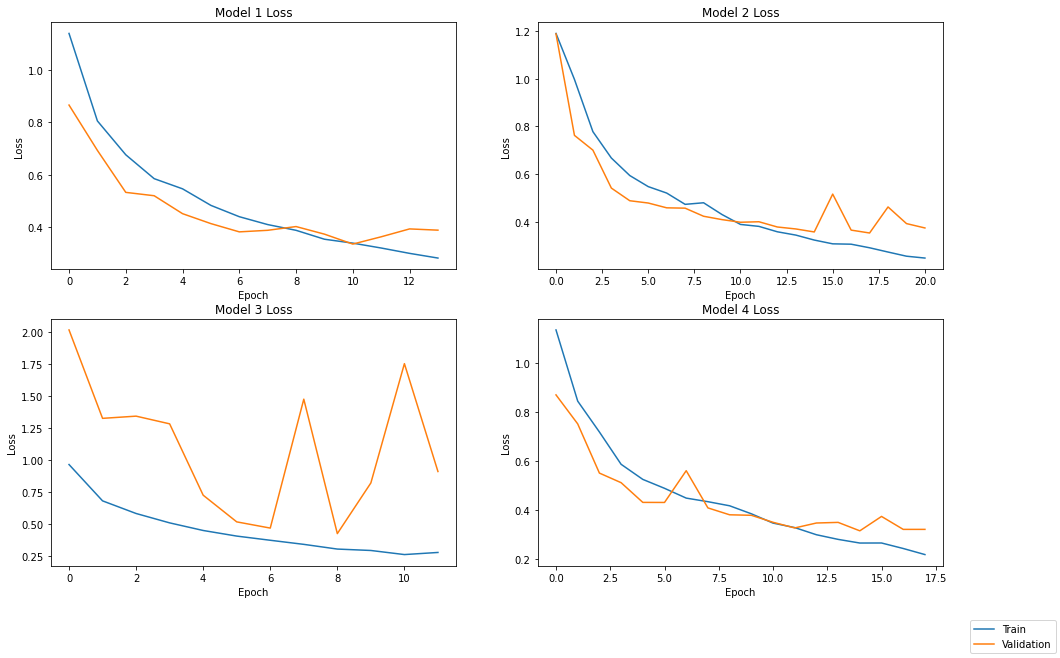

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(16, 10))
axs[0,0].plot(history.history['loss'])
axs[0,0].plot(history.history['val_loss'])
axs[0,0].set_title('Model 1 Loss')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_xlabel('Epoch')

axs[0,1].plot(history2.history['loss'])
axs[0,1].plot(history2.history['val_loss'])
axs[0,1].set_title('Model 2 Loss')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_xlabel('Epoch')

axs[1,0].plot(history3.history['loss'])
axs[1,0].plot(history3.history['val_loss'])
axs[1,0].set_title('Model 3 Loss')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')

axs[1,1].plot(history4.history['loss'])
axs[1,1].plot(history4.history['val_loss'])
axs[1,1].set_title('Model 4 Loss')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_xlabel('Epoch')
fig.legend(['Train', 'Validation'], loc = 'lower right')
fig.show()

Ήδη απο τα plots των Losses βλέπουμε οτι το μοντέλο 3 έχει πάθει overfitting άρα το αποκλείουμε. 

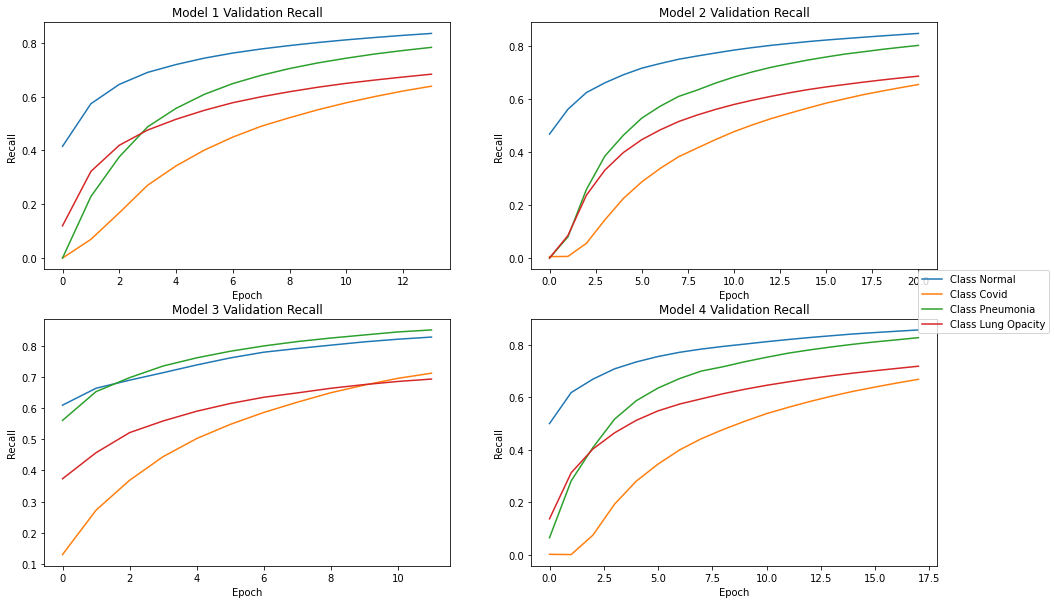

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(16, 10))
axs[0,0].plot(history.history['val_recall_Normal'])
axs[0,0].plot(history.history['val_recall_Covid'])
axs[0,0].plot(history.history['val_recall_Pneumonia'])
axs[0,0].plot(history.history['val_recall_LungOP'])
axs[0,0].set_title('Model 1 Validation Recall')
axs[0,0].set_ylabel('Recall')
axs[0,0].set_xlabel('Epoch')

axs[0,1].plot(history2.history['val_recall_Normal'])
axs[0,1].plot(history2.history['val_recall_Covid'])
axs[0,1].plot(history2.history['val_recall_Pneumonia'])
axs[0,1].plot(history2.history['val_recall_LungOP'])
axs[0,1].set_title('Model 2 Validation Recall')
axs[0,1].set_ylabel('Recall')
axs[0,1].set_xlabel('Epoch')

axs[1,0].plot(history3.history['val_recall_Normal'])
axs[1,0].plot(history3.history['val_recall_Covid'])
axs[1,0].plot(history3.history['val_recall_Pneumonia'])
axs[1,0].plot(history3.history['val_recall_LungOP'])
axs[1,0].set_title('Model 3 Validation Recall')
axs[1,0].set_ylabel('Recall')
axs[1,0].set_xlabel('Epoch')

axs[1,1].plot(history4.history['val_recall_Normal'])
axs[1,1].plot(history4.history['val_recall_Covid'])
axs[1,1].plot(history4.history['val_recall_Pneumonia'])
axs[1,1].plot(history4.history['val_recall_LungOP'])
axs[1,1].set_title('Model 4 Validation Recall')
axs[1,1].set_ylabel('Recall')
axs[1,1].set_xlabel('Epoch')
fig.legend(['Class Normal', 'Class Covid','Class Pneumonia','Class Lung Opacity'], loc = 'center right')
fig.show()

In [ ]:
average_val_recall1 = (history.history['val_recall_Normal'][-1] + history.history['val_recall_Covid'][-1] + history.history['val_recall_Pneumonia'][-1] + history.history['val_recall_LungOP'][-1])/4
print('avg Recall for model 1 = ',average_val_recall1)
average_val_recall2 = (history2.history['val_recall_Normal'][-1] + history2.history['val_recall_Covid'][-1] + history2.history['val_recall_Pneumonia'][-1] + history2.history['val_recall_LungOP'][-1])/4
print('avg Recall for model 2 = ',average_val_recall2)
average_val_recall3 = (history3.history['val_recall_Normal'][-1] + history3.history['val_recall_Covid'][-1] + history3.history['val_recall_Pneumonia'][-1] + history3.history['val_recall_LungOP'][-1])/4
print('avg Recall for model 3 = ',average_val_recall3)
average_val_recall4 = (history4.history['val_recall_Normal'][-1] + history4.history['val_recall_Covid'][-1] + history4.history['val_recall_Pneumonia'][-1] + history4.history['val_recall_LungOP'][-1])/4
print('avg Recall for model 4 = ',average_val_recall4)


avg Recall for model 1 =  0.734878197312355
avg Recall for model 2 =  0.7463730573654175
avg Recall for model 3 =  0.7712816894054413
avg Recall for model 4 =  0.7668922245502472


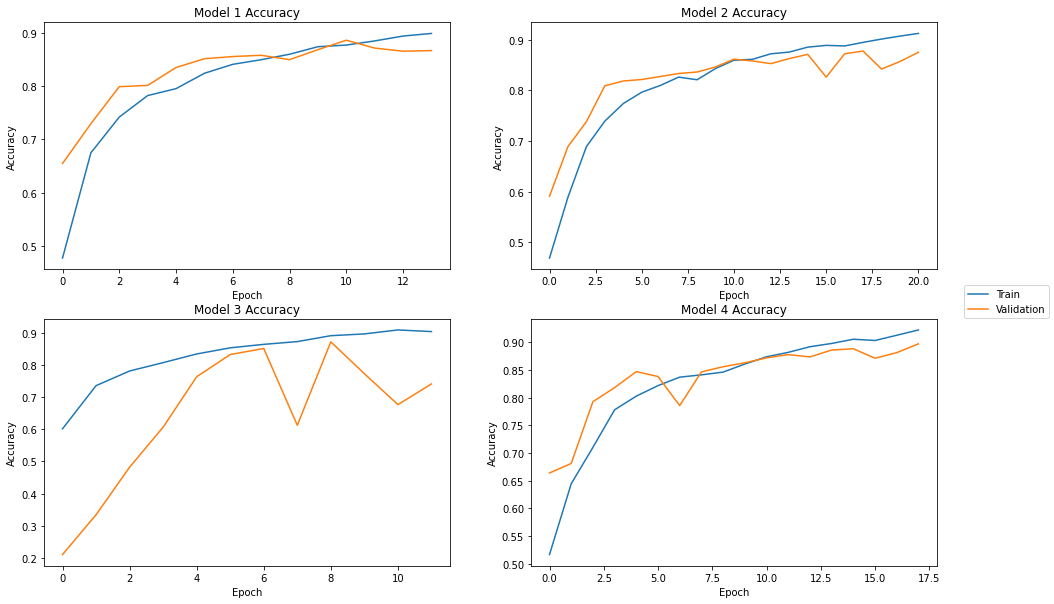

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(16, 10))
axs[0,0].plot(history.history['sparse_categorical_accuracy'])
axs[0,0].plot(history.history['val_sparse_categorical_accuracy'])
axs[0,0].set_title('Model 1 Accuracy')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_xlabel('Epoch')

axs[0,1].plot(history2.history['sparse_categorical_accuracy'])
axs[0,1].plot(history2.history['val_sparse_categorical_accuracy'])
axs[0,1].set_title('Model 2 Accuracy')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].set_xlabel('Epoch')

axs[1,0].plot(history3.history['sparse_categorical_accuracy'])
axs[1,0].plot(history3.history['val_sparse_categorical_accuracy'])
axs[1,0].set_title('Model 3 Accuracy')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_xlabel('Epoch')

axs[1,1].plot(history4.history['sparse_categorical_accuracy'])
axs[1,1].plot(history4.history['val_sparse_categorical_accuracy'])
axs[1,1].set_title('Model 4 Accuracy')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_xlabel('Epoch')
fig.legend(['Train', 'Validation'], loc = 'center right')
fig.show()

Την καλύτερη απόδοση την έχουν τα μοντέλα 1 και 4. Το μοντέλο 3 έχει πάθει overfitting και το μοντέλο 2 στο τελευταίο Layer CNN έχει 64 filters, άρα και λιγότερα features στην έξοδό του. Αυτό που θα προτιμήσουμε είναι το μοντέλο 4 με περίπου 22 million παραμέτρους και κάτω απο 0.4 loss έναντι του μοντέλου 1 με 25 million παραμέτρους και λιγό πάνω απο 0.4 loss.  

In [ ]:
# from keras.models import load_model

def createNeuralNetFinal():
  model = Sequential()    #128

  model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
  model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
                            #64
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
                            #64
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  
  model.add(Dropout(0.3)) #0.5 without cw
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(4,activation = 'softmax')) #for Covid/Normal/Pneumonia/Lung_opacity maybe we need activation softmax
  model.load_weights('myCNNmodel4_W_finalv2.h5')
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#learning_rate=0.001
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                # run_eagerly=True,

                # metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),keras_metrics.sparse_categorical_recall(label=0,name='recall_Normal'),
                #          keras_metrics.sparse_categorical_recall(label=1,name='recall_Covid'),
                #          keras_metrics.sparse_categorical_recall(label=2,name='recall_Pneumonia'),
                #          keras_metrics.sparse_categorical_recall(label=3,name='recall_LungOP')]
                ) 
  model.summary()
  return model



modelFinal = createNeuralNetFinal()
# loss, acc = modelFinal.evaluate(x_test, y_test, verbose=2)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 68, 68, 16)        448       
                                                                 
 conv2d_22 (Conv2D)          (None, 66, 66, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 33, 33, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 33, 33, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                 

# Evaluation

Ας κάνουμε τώρα ένα Evaluation για να δούμε τι έμαθε το μοντέλο, ώστε αν χρειαστεί να αλλάξουμε τις παραμέτρους του.


Val Dur =  0.7435469627380371
Test Dur =  1.5845167636871338

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       816
           1       0.89      0.86      0.87       289
           2       0.93      0.92      0.93       108
           3       0.90      0.81      0.85       481

    accuracy                           0.89      1694
   macro avg       0.90      0.88      0.89      1694
weighted avg       0.89      0.89      0.89      1694

--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2038
           1       0.89      0.90      0.90       723
           2       0.96      0.97      0.97       269
           3       0.91      0.80      0.85      1203

    accuracy                           0.90      4233
   macro avg       0.

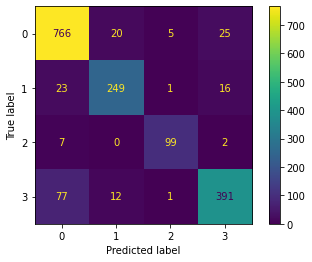

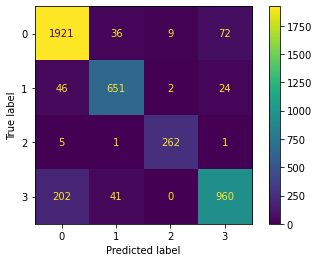

In [ ]:
import time
# start1 = time.time()
# yp_train = model.predict(x_train)
# duration1 = time.time() - start1

# yp_train = np.argmax(yp_train, axis = 1)

start2 = time.time()
yp_val = modelFinal.predict(x_val)
duration2 = time.time() - start2
print("Val Dur = ",duration2)
yp_val = np.argmax(yp_val, axis = 1)

start3 = time.time()
yp_test = modelFinal.predict(x_test)
duration3 = time.time() - start3
print("Test Dur = ",duration3)
yp_test = np.argmax(yp_test, axis = 1)

def evaluation( y_val, yp_val, y_test, yp_test):
    
    
    # cm_train = confusion_matrix(y_train, yp_train)
    # t1 = ConfusionMatrixDisplay(cm_train)
    # # s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    # print("Classification Report for Train Data\n")
    # print(classification_report(y_train, yp_train)) 
    # print("--------------------------------------------------------------------------")

       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    # s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    # s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")

    
    # t1.plot()
    t2.plot()   
    t3.plot()
evaluation( y_val, yp_val, y_test, yp_test)


Ας δούμε ένα prediction απο μια τυχαία εικόνα του test set. Εκτός απο το target label θα εμφανίζω και την postirior πιθανότητα. 

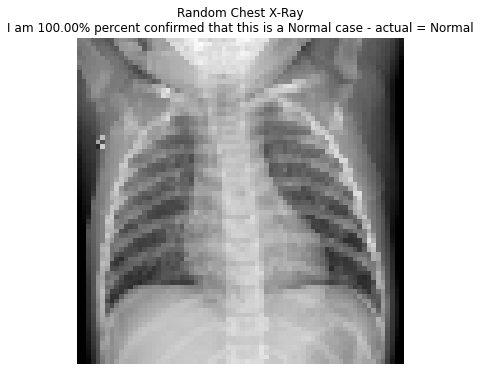

In [ ]:
# Testing with Random Chest X-Ray from test set
import random

# image_idx = random.choice(len(x_test))
# image = cv2.imread(data['path'][2])
# image = cv2.resize(image, (70, 70)) / 255.0
# image = x_test[0]
# print(image.shape)
# print(image)
# hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
# pp_hardik_img = image.img_to_array(hardik_img)
# pp_hardik_img = pp_hardik_img/255
# pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
i = np.random.randint(0, x_test.shape[0])
# plt.imshow(x_test[i], cmap='gray')
x = np.expand_dims(x_test[i],axis=0)
y_actual = np.expand_dims(y_test[i],axis=0)
# print("actual = ",y_test[i])
prediction= modelFinal.predict(x)
# print(prediction)
y = np.argmax(prediction, axis = 1)
# print(y)
# print(prediction[0][y])
plt.figure(figsize=(6,6))
plt.axis('off')
case = ''

if y[0] == 0:
  case = "Normal"
elif y[0] == 1:
  case = "Covid"
elif y[0] == 2:
  case = "Pneumonia"
else:
  case = "Lung Opacity"
caseReal = ''
if y_actual[0] == 0:
  caseReal = "Normal"
elif y_actual[0] == 1:
  caseReal = "Covid"
elif y_actual[0] == 2:
  caseReal = "Pneumonia"
else:
  caseReal = "Lung Opacity"
out = (f'I am {prediction[0][y][0]:.2%} percent confirmed that this is a {case} case - actual = {caseReal}')

plt.title("Random Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(x))
plt.show()

#Grad-CAM Analysis

Λόγω limitations του Colab, Δεν μπορώ να εφαρμόσω explainability σε όλα τα Layers και για αυτό θα πάρουμε τα activations του τελευταίου Convolution Layer, το οποίο είναι αυτό που βγάζει και τα πιο πολλά features στην έξοδο προς τα Fully Connected. Έπειτα με ειδικό χρωματισμό πάνω στην εικόνα θα υποδείξουμε στον τελικό χρήστη ποιά σημεία της επιρέασαν το αποτέλεσμα.  

[[3.8170707e-04 9.9484360e-01 6.7503961e-06 4.7678156e-03]]


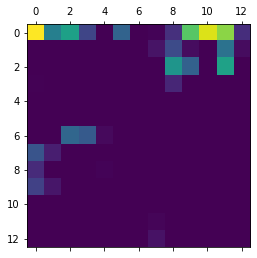

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
image = cv2.imread("/content/drive/My Drive/DeepLearning/archive/COVID-19_Radiography_Dataset/COVID/images/COVID-20.png")
# img = image.img_to_array(cv2.resize(image, (70, 70)))
# img = img/255
# img = np.expand_dims(img, axis=0)
imageresized = cv2.resize(image, (70, 70)) / 255.0
img = np.expand_dims(imageresized,axis=0)
preds = modelFinal.predict(img)
print(preds)

# Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
heatmap = make_gradcam_heatmap(img, modelFinal, "conv2d_24",0 )

# Display heatmap
plt.matshow(heatmap)
plt.show()

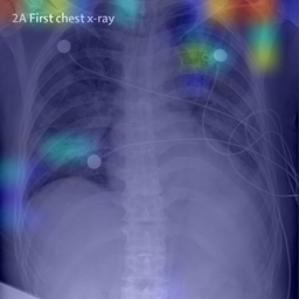

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    # img = img_path # kmouts

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

path = '/content/drive/My Drive/DeepLearning/archive/COVID-19_Radiography_Dataset/COVID/images/COVID-20.png'
save_and_display_gradcam(path, heatmap)

# Transfer Learning as Classifier

Αρχικά θα χρησιμοπιήσουμε το VGG19 με βάρη που έχουν αποκτηθεί απο το imagenet. 

Θα κάνουμε Freeze τα Layers του και θα προσθέσουμε κάποια extra fully connected Layers για το δικό μας classification.  

In [ ]:
# from skimage.transform import resize
# listOfresized = list()
# for i in range(len(x_train)):
#     x_train_resized = resize(x_train[i], (224, 224))
#     listOfresized.append(x_train_resized)
# listOfresized = np.array(listOfresized)

# print(listOfresized.shape)
def vgg19_model_notIncludeLastLayers(input_shape):
    
    input_img = tf.keras.Input(input_shape)
    
    base = tf.keras.applications.VGG19(input_shape = input_shape, weights = 'imagenet',
                                                   include_top = False, input_tensor = input_img)
    
    base.trainable = False
    
    A0 = base.output
    flat1 = Flatten()(A0)
    classes = Dense(1024, activation = 'relu')(flat1)
    drops = Dropout(0.5)(classes)
    class1 = Dense(16, activation='relu')(drops)
    class1 = Dropout(0.2)(class1)
    outputs = Dense(4, activation='softmax')(class1)
    # A1 = layer.GlobalAveragePooling2D( )(A0)
    # N1 = layer.BatchNormalization()(A1)
    # N1 = layer.Dropout(0.1)(N1)
    
    # A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
    #                  units=3072, activation='relu')(N1)
    # N2 = layer.BatchNormalization()(A2)
    # N2 = layer.Dropout(0.2)(N2)
    
    # A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
    #                  units=512, activation='relu')(N2)
    # N3 = layer.BatchNormalization()(A3)
    # N3 = layer.Dropout(0.4)(N3)
    
    # outputs = layer.Dense(units = 4, activation = 'softmax')(N3) #we neet 4 units one for each class
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

def vgg19_model_IncludeLastLayers(input_shape):
    
    input_img = tf.keras.Input(input_shape)
    
    base = tf.keras.applications.VGG19(input_shape = input_shape, weights = 'imagenet',
                                                   include_top = True, input_tensor = input_img)
    
    base.trainable = False
    
    A0 = base.output
    flat1 = Flatten()(A0)
    classes = Dense(1024, activation = 'relu')(flat1)
    drops = Dropout(0.5)(classes)
    class1 = Dense(16, activation='relu')(drops)
    class1 = Dropout(0.2)(class1)
    outputs = Dense(4, activation='softmax')(class1)
    # A1 = layer.GlobalAveragePooling2D( )(A0)
    # N1 = layer.BatchNormalization()(A1)
    # N1 = layer.Dropout(0.1)(N1)
    
    # A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
    #                  units=3072, activation='relu')(N1)
    # N2 = layer.BatchNormalization()(A2)
    # N2 = layer.Dropout(0.2)(N2)
    
    # A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
    #                  units=512, activation='relu')(N2)
    # N3 = layer.BatchNormalization()(A3)
    # N3 = layer.Dropout(0.4)(N3)
    
    # outputs = layer.Dense(units = 4, activation = 'softmax')(N3) #we neet 4 units one for each class
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

In [ ]:
checkpoint = 'vgg19_v1.h5'
checkpoint_dir = os.path.dirname(checkpoint)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint,
                                                save_weights_only=True,
                                                save_freq ='epoch',
                                                verbose=1)

stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=3,
                                         mode="min",
                                         restore_best_weights=True)
vgg19_model_notIncludeTop = vgg19_model_notIncludeLastLayers((70, 70, 3)) #maybe must be changed
vgg19_model_notIncludeTop.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                     metrics=['accuracy'])
vgg19_model_notIncludeTop.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 70, 70, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 70, 70, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 35, 35, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 35, 35, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 35, 35, 128)       147584    
                                                            

## Training

In [ ]:
vgg19_model_history1 = vgg19_model_notIncludeTop.fit(x_train,y_train, epochs=50, batch_size = 128,validation_data=(x_val,y_val), callbacks=[ stop])
vgg19_model_notIncludeTop.save(checkpoint)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


120/120 [==============================] - 14s 97ms/step - loss: 0.9272 - accuracy: 0.5986 - val_loss: 0.6566 - val_accuracy: 0.7349
Epoch 2/50
120/120 [==============================] - 11s 89ms/step - loss: 0.7092 - accuracy: 0.7141 - val_loss: 0.5703 - val_accuracy: 0.7816
Epoch 3/50
120/120 [==============================] - 11s 91ms/step - loss: 0.6448 - accuracy: 0.7439 - val_loss: 0.5540 - val_accuracy: 0.7798
Epoch 4/50
120/120 [==============================] - 11s 89ms/step - loss: 0.6082 - accuracy: 0.7646 - val_loss: 0.4879 - val_accuracy: 0.8152
Epoch 5/50
120/120 [==============================] - 11s 89ms/step - loss: 0.5811 - accuracy: 0.7786 - val_loss: 0.4771 - val_accuracy: 0.8123
Epoch 6/50
120/120 [==============================] - 11s 88ms/step - loss: 0.5618 - accuracy: 0.7864 - val_loss: 0.4873 - val_accuracy: 0.8052
Epoch 7/50
120/120 [==============================] - 11s 92ms/step - loss: 0.5427 - accuracy: 0.7935 - val_loss: 0.4531 - val_accuracy: 0.8300
Epo

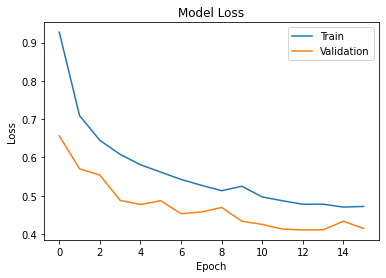

In [ ]:
plt.plot(vgg19_model_history1.history['loss'])
plt.plot(vgg19_model_history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

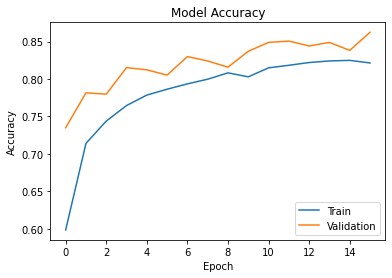

In [ ]:
plt.plot(vgg19_model_history1.history['accuracy'])
plt.plot(vgg19_model_history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

# Transfer Learning as Feature Extractor

Τέλος θα χρησιμοποιήσουμε το ResNet152 με βάρη απο το imagenet, έτσι ώστε να πάρουμε features απο το τελευταίο του Layer με σκοπό να τα περάσουμε ως είσοδο σε RandomForest και σε GradientBoosting. Έτσι θα πρέπει μόνο να εκπαιδεύσουμε αυτούς τους classifiers με απλές τεχνικές Machine Learning. 

In [4]:

from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet152
from keras.models import Model
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,cross_val_score
# load model
input_shape = (70,70,3)
input_img = tf.keras.Input(input_shape)
    
model = VGG19(input_shape = input_shape, weights = 'imagenet',
                                                   include_top = False, input_tensor = input_img)
# model = VGG19(input_shape = input_shape)
# remove the output layer
# features = model.layer[-1].output
model_new = Model(inputs=model.inputs, outputs=model.layers[-1].output)
# get extracted features
features = model_new.predict(x_train)
features_val = model_new.predict(x_val)

nsamples,n, nx, ny = features.shape
x_train_new = features.reshape(nsamples,n*nx*ny)
nsamples,n, nx, ny = features_val.shape
x_val_new = features_val.reshape(nsamples,n*nx*ny)
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(x_train_new, y_train)

# param_grid = {'n_estimators':[10,50,100,200,300,500]
              
#               }
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0)


# grid.fit(X, y)
# # print best parameter after tuning
# print(grid.best_params_)
# grid_predictions = grid.predict(x_val_new)
# # print classification report
# print(metrics.classification_report(x_val_new, grid_predictions))

clf3 = RandomForestClassifier(n_estimators = 600).fit(X,y)
y_pred = clf3.predict(x_val_new)
predicted_prob2 = clf3.predict_proba(x_val_new)
m_confusion_test = metrics.confusion_matrix(y_val, y_pred)
print("RF")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],index=['Actual 0', 'Actual 1','Actual 2','Actual 3']))
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_pred,y_val))

clf4 = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 300).fit(X,y)
y_pred = clf4.predict(x_val_new)
predicted_prob2 = clf4.predict_proba(x_val_new)
m_confusion_test = metrics.confusion_matrix(y_val, y_pred)
print("GBC")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],index=['Actual 0', 'Actual 1','Actual 2','Actual 3']))
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_pred,y_val))

for clf, label in zip([clf3,clf4],
                      [
                       'Random Forest',
                       'GBC'
                       ]):

    scoresTest = cross_val_score(clf, x_val_new, y_val,
                                             cv=3, scoring='accuracy')
    scores2Test = cross_val_score(clf, x_val_new, y_val,
                                             cv=3, scoring='f1_macro')
    print("Accuracy on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scoresTest.mean(), scoresTest.std(), label))
    print("F1-Score on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scores2Test.mean(), scores2Test.std(), label))



80150528/80134624 [==============================] - 1s 0us/step
RF
          Predicted 0  Predicted 1  Predicted 2  Predicted 3
Actual 0          694           42           16           64
Actual 1           42          217            3           27
Actual 2            6            0           98            4
Actual 3           71           37            2          371
Accuracy: 0.8146399055489965
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       813
           1       0.75      0.73      0.74       296
           2       0.91      0.82      0.86       119
           3       0.77      0.80      0.78       466

    accuracy                           0.81      1694
   macro avg       0.82      0.80      0.81      1694
weighted avg       0.82      0.81      0.81      1694

GBC
          Predicted 0  Predicted 1  Predicted 2  Predicted 3
Actual 0          631           84           34           67
Actual 1           49          204   